In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recsysmasterfds/train.csv
/kaggle/input/recsysmasterfds/kaggle_baseline.csv


# Read the data

In [2]:
!pip install -q tensorflow-ranking
!pip install -q tensorflow-recommenders

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [3]:
import matplotlib.pylab as plt
from tqdm import tqdm 

In [4]:
train = pd.read_csv('/kaggle/input/recsysmasterfds/train.csv', names=['uid', 'title', 'mid', 'rating', 'genre', 'age', 'sex'], header=0)
test = pd.read_csv('/kaggle/input/recsysmasterfds/kaggle_baseline.csv', names=['uid', 'prediction'], header=0)

In [5]:
train.head()

,uid,title,mid,rating,genre,age,sex
0,2592,Top Gun (1986),1101,4,Action|Romance,50,M
1,4318,12 Angry Men (1957),1203,4,Drama,25,M
2,2756,Robocop 2 (1990),2986,2,Action|Crime|Sci-Fi,18,M
3,1706,Modern Times (1936),3462,5,Comedy,25,M
4,4813,Milk Money (1994),276,3,Comedy|Romance,35,F


# Data Preprocessing

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_ranking as tfr
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pathlib import Path
from zipfile import ZipFile
!mkdir models

### We load the Movielens data set to have more features

We download the movielens dataset to use more features. Since we don't want to add more ratings to our training set, because they might overlap with the test set that we are given, we will add the user and movie information to the data that we have in our training set.

In [7]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-1m.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-1m"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as z:
        # Extract files
        print("Extracting all the files now...")
        z.extractall(path=keras_datasets_path)
        print("Done!")

5917549/5917549 [==============================] - 2s 0us/step
Extracting all the files now...
Done!


In [8]:
def load_ratings(movielens_dir):
    COL_NAME = ['uid','mid','rating','timestamp']
    df = pd.read_csv(movielens_dir / 'ratings.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df

def load_movies(movielens_dir):
    COL_NAME = ['mid','movie_name','movie_genre']
    df = pd.read_csv(movielens_dir / 'movies.dat',sep='::', header=None, engine='python', names=COL_NAME, encoding='latin-1')
    return df

def load_users(movielens_dir):
    COL_NAME = ['uid','gender','age','occupation','postal_code']
    df = pd.read_csv(movielens_dir / 'users.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df

def text2seq(text, n_genre):
    """ using tokenizer to encoded the multi-level categorical feature
    """
    tokenizer = Tokenizer(lower=True, split='|',filters='', num_words=n_genre)
    tokenizer.fit_on_texts(text)
    seq = tokenizer.texts_to_sequences(text)
    seq = pad_sequences(seq, maxlen=3,padding='post')
    return seq

n_genre = 15

ratings = load_ratings(movielens_dir)
movies = load_movies(movielens_dir)
users = load_users(movielens_dir)

print("====== rating.dat ======")
print(ratings.head())
print("===== movies.dat ======")
print(movies.head())
print("====== users.dat ======")
print(users.head())

movies['movie_genre'] = text2seq(movies.movie_genre.values, n_genre=n_genre).tolist()

ratings = ratings.join(movies.set_index('mid'), on = 'mid', how = 'left')
ratings = ratings.join(users.set_index('uid'), on = 'uid', how = 'left')
print("====== preprocessed data =======")
(ratings.head())

====== rating.dat ======
   uid   mid  rating  timestamp
0    1  1193       5  978300760
1    1   661       3  978302109
2    1   914       3  978301968
3    1  3408       4  978300275
4    1  2355       5  978824291
===== movies.dat ======
   mid                          movie_name                   movie_genre
0    1                    Toy Story (1995)   Animation|Children's|Comedy
1    2                      Jumanji (1995)  Adventure|Children's|Fantasy
2    3             Grumpier Old Men (1995)                Comedy|Romance
3    4            Waiting to Exhale (1995)                  Comedy|Drama
4    5  Father of the Bride Part II (1995)                        Comedy
====== users.dat ======
   uid gender  age  occupation postal_code
0    1      F    1          10       48067
1    2      M   56          16       70072
2    3      M   25          15       55117
3    4      M   45           7       02460
4    5      M   25          20       55455
====== preprocessed data =======


,uid,mid,rating,timestamp,movie_name,movie_genre,gender,age,occupation,postal_code
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),"[1, 0, 0]",F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),"[9, 13, 0]",F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),"[13, 5, 0]",F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),"[1, 0, 0]",F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)","[9, 2, 0]",F,1,10,48067


### Of all the ratings in the MovieLens dataset we only keep those that are in the training set that we are given

In [9]:
merged = pd.merge(ratings, train, on=['uid', 'mid'], how='left', indicator=True)
ratings = merged[merged['_merge'] == 'both']
cols = ['uid', 'mid', 'rating_x', 'timestamp', 'movie_name', 'movie_genre', 'gender', 'age_x', 'occupation', 'postal_code']
ratings = ratings[cols]
ratings.rename(columns = {'rating_x':'rating', 'age_x':'age'}, inplace = True)
ratings['rating'] = ratings['rating'].astype(float)
ratings.head(10)

,uid,mid,rating,timestamp,movie_name,movie_genre,gender,age,occupation,postal_code
0,1,1193,5.0,978300760,One Flew Over the Cuckoo's Nest (1975),"[1, 0, 0]",F,1,10,48067
1,1,661,3.0,978302109,James and the Giant Peach (1996),"[9, 13, 0]",F,1,10,48067
3,1,3408,4.0,978300275,Erin Brockovich (2000),"[1, 0, 0]",F,1,10,48067
4,1,2355,5.0,978824291,"Bug's Life, A (1998)","[9, 2, 0]",F,1,10,48067
5,1,1197,3.0,978302268,"Princess Bride, The (1987)","[7, 2, 5]",F,1,10,48067
6,1,1287,5.0,978302039,Ben-Hur (1959),"[3, 7, 1]",F,1,10,48067
7,1,2804,5.0,978300719,"Christmas Story, A (1983)","[2, 1, 0]",F,1,10,48067
8,1,594,4.0,978302268,Snow White and the Seven Dwarfs (1937),"[9, 13, 0]",F,1,10,48067
10,1,595,5.0,978824268,Beauty and the Beast (1991),"[9, 13, 0]",F,1,10,48067
11,1,938,4.0,978301752,Gigi (1958),"[13, 0, 0]",F,1,10,48067


## Split the data

In [10]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(ratings, test_size=0.1, stratify=ratings.rating)

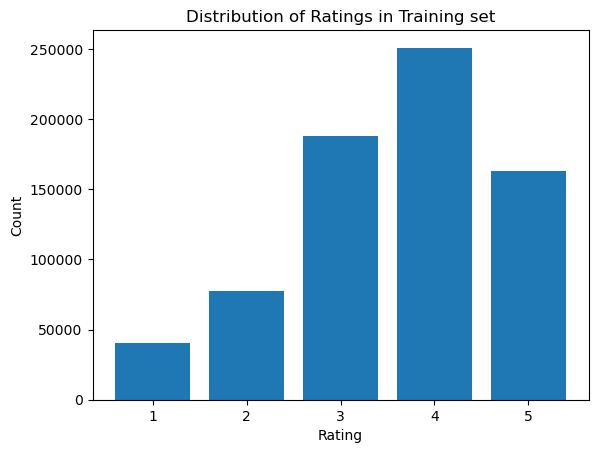

In [11]:
import matplotlib.pyplot as plt

# count the number of values in the rating column
rating_counts = train['rating'].value_counts()
# create the bar chart
plt.bar(rating_counts.index, rating_counts.values)
# add labels and title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in Training set')
# show the plot
plt.show()

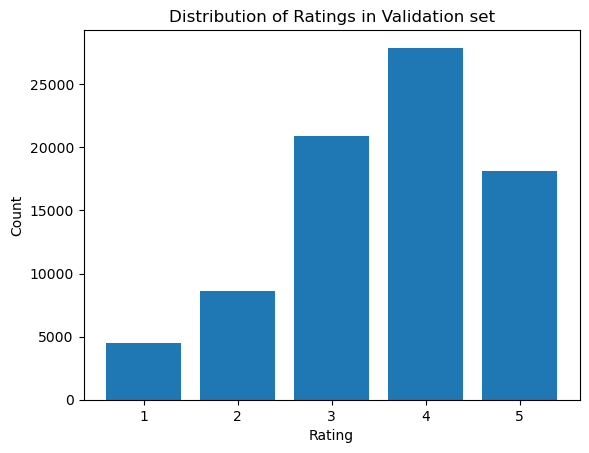

In [12]:
import matplotlib.pyplot as plt

# count the number of values in the rating column
rating_counts = val['rating'].value_counts()
# create the bar chart
plt.bar(rating_counts.index, rating_counts.values)
# add labels and title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in Validation set')
# show the plot
plt.show()

## Data engineering and preprocessing

In [13]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
def weight_func(rating):
    if rating >= 4:
        return 1
    else:
        return 0.1
    
def relevant_func(rating):
    if rating >= 4:
        return 1
    else:
        return 0
    
def preprocess(train, val=None):
    # ========================== FEATURE ENGINEERING ========================================
    # RATING NORMALIZATION
    min_rating = train['rating'].values.min()
    max_rating = train['rating'].values.max()
    train['norm_rating'] = (train['rating'] - min_rating) / (max_rating - min_rating)

    # MOVIE POPULARITY
    train['popularity'] = train.groupby('mid')['mid'].transform('count')
    unique_combinations = train[['mid', 'popularity']].drop_duplicates()
    
    # MEAN MOVIE RATING
    mean_ratings = train.groupby('mid', as_index=False)['rating'].mean()
    mean_ratings.columns = ['mid', 'mean_mid']
    train = pd.merge(train, mean_ratings, on='mid', how='left')
    
    # NORMALIZE MEAN MOVIE RATING
    min_mean_mid = train['mean_mid'].values.min()
    max_mean_mid = train['mean_mid'].values.max()
    train['norm_mean_mid'] = (train['mean_mid'] - min_mean_mid) / (max_mean_mid - min_mean_mid)
    
    # MEAN USER RATING
    mean_ratings_uid = train.groupby('uid', as_index=False)['rating'].mean()
    mean_ratings_uid.columns = ['uid', 'mean_uid']
    train = pd.merge(train, mean_ratings_uid, on='uid', how='left')
    
    # NORMALIZE MEAN USER RATING
    min_mean_uid = train['mean_uid'].values.min()
    max_mean_uid = train['mean_uid'].values.max()
    train['norm_mean_uid'] = (train['mean_uid'] - min_mean_uid) / (max_mean_uid - min_mean_uid)
    
    # NORMALIZE POPULARITY
    min_pop = train['popularity'].values.min()
    max_pop = train['popularity'].values.max()
    train['norm_pop'] = (train['popularity'] - min_pop) / (max_pop - min_pop)
    
    # ENCODE THE GENDER
    gender_encoder = LabelEncoder()
    gender_encoder.fit(train['gender'])
    train['gender_encoded'] = gender_encoder.transform(train['gender'])

    # NORMALIZE THE AGE
    min_age = train['age'].values.min()
    max_age = train['age'].values.max()
    train['norm_age'] = (train['age'] - min_age) / (max_age - min_age)
    
    # CREATE MOVIE YEAR
    train['movie_year'] = (train['movie_name'].str.extract(r'\((\d{4})\)$')).astype(int)
    
    # NORMALIZE THE YEAR
    min_year = train['movie_year'].values.min()
    max_year = train['movie_year'].values.max()
    train['norm_year'] = (train['movie_year'] - min_year) / (max_year - min_year)

    # =======================================================================================
    # CREATE WEIGHTS FOR TRAINING
    train['weight'] = train['rating'].apply(weight_func)
    
    # CREATE TARGET
    train['relevant'] = train['rating'].apply(relevant_func)
    
    train.fillna(0, inplace=True)
    
    if val is not None:
        val['norm_rating'] = (val['rating'] - min_rating) / (max_rating - min_rating)
        val = pd.merge(val, unique_combinations, on='mid', how='left')
        val = pd.merge(val, mean_ratings, on='mid', how='left')
        val['norm_mean_mid'] = (val['mean_mid'] - min_mean_mid) / (max_mean_mid - min_mean_mid)
        val = pd.merge(val, mean_ratings_uid, on='uid', how='left')
        val['norm_mean_uid'] = (val['mean_uid'] - min_mean_uid) / (max_mean_uid - min_mean_uid)
        val['norm_pop'] = (val['popularity'] - min_pop) / (max_pop - min_pop)
        val['gender_encoded'] = gender_encoder.transform(val['gender'])
        val['norm_age'] = (val['age'] - min_age) / (max_age - min_age)
        val['movie_year'] = (val['movie_name'].str.extract(r'\((\d{4})\)$')).astype(int)
        val['norm_year'] = (val['movie_year'] - min_year) / (max_year - min_year)
        val['relevant'] = val['rating'].apply(relevant_func)
        val.fillna(0, inplace=True)

        return train, val
    
    return train

In [14]:
train, val = preprocess(train, val)

In [15]:
train_complete = preprocess(ratings)

In [16]:
def preprocess_test(data, train):
    
    # MOVIE POPULARITY
    unique_combinations = train[['mid', 'popularity']].drop_duplicates()
    data = pd.merge(data, unique_combinations, on='mid', how='left')
    
    # MEAN RATING
    mean_ratings = train.groupby('mid', as_index=False)['rating'].mean()
    mean_ratings.columns = ['mid', 'mean_mid']
    data = pd.merge(data, mean_ratings, on='mid', how='left')
    
    # NORMALIZE MEAN RATING
    min_mean_mid = train['mean_mid'].values.min()
    max_mean_mid = train['mean_mid'].values.max()
    data['norm_mean_mid'] = (data['mean_mid'] - min_mean_mid) / (max_mean_mid - min_mean_mid)
    
    # MEAN USER RATING
    mean_ratings = train.groupby('uid', as_index=False)['rating'].mean()
    mean_ratings.columns = ['uid', 'mean_uid']
    data = pd.merge(data, mean_ratings, on='uid', how='left')
    
    # NORMALIZE MEAN USER RATING
    min_mean_uid = train['mean_uid'].values.min()
    max_mean_uid = train['mean_uid'].values.max()
    data['norm_mean_uid'] = (data['mean_uid'] - min_mean_uid) / (max_mean_uid - min_mean_uid)

    # NORMALIZE POPULARITY
    min_pop = train['popularity'].values.min()
    max_pop = train['popularity'].values.max()
    data['norm_pop'] = (data['popularity'] - min_pop) / (max_pop - min_pop)
    
    # ENCODE THE GENDER
    gender_encoder = LabelEncoder()
    gender_encoder.fit(train['gender'])
    data['gender_encoded'] = gender_encoder.transform(data['gender'])

    # NORMALIZE THE AGE
    min_age = train['age'].values.min()
    max_age = train['age'].values.max()
    data['norm_age'] = (data['age'] - min_age) / (max_age - min_age)
    
    # CREATE MOVIE YEAR
    data['movie_year'] = (data['movie_name'].str.extract(r'\((\d{4})\)$')).astype(int)

    # NORMALIZE THE YEAR
    min_year = train['movie_year'].values.min()
    max_year = train['movie_year'].values.max()
    data['norm_year'] = (data['movie_year'] - min_year) / (max_year - min_year)
    
    data.fillna(0, inplace=True)
    return data

# Top Popular

In [17]:
class TopPopRecommender():

    def fit(self, train):

        item_popularity = train[['mid','rating']].groupby(by='mid').count()

        self.train = train
        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = item_popularity.sort_values(by='rating',ascending=False).index
    
    
    def recommend(self, user_id, at=25, remove_seen=True):

        if remove_seen:
            seen_items = self.train[self.train.uid==user_id].mid.values
            unseen_items_mask = np.in1d(self.popular_items, seen_items, assume_unique=True, invert = True)
            unseen_items = self.popular_items[unseen_items_mask]
            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.popular_items[0:at]
    
        return recommended_items

In [18]:
TOP_model_comp = TopPopRecommender()
TOP_model_comp.fit(train_complete)

In [19]:
TOP_model = TopPopRecommender()
TOP_model.fit(train)

# 1st Approach: User and item based CF
We first attempted to approach the problem using a Neighbourhood based Collaborative Filtering Method. We evaluated our training and validation sets with both user based and item based models and they both performed the same.
Also, to try to handle the cold start problem, meaning when a user has little ratings, we combined the user based model with a top popular recommender. Then, if a user has less ratings than a certain threshold, instead of getting personalized recommendations they would get the top popular movies recommended.

In [20]:
class CollaborativeFiltering:
    """ Collaborative filtering using a custom sim(u,u'). """
    
    def __init__(self, _type = 'item'):
        """ Constructor """
        self._type = _type
    
    def fit(self,df_train,shrink = 10):
        """ Prepare data structures for estimation. Similarity matrix for users """
        print("Learning...")
        self.df_train=df_train
        self.urm_train = pd.pivot_table(df_train[['uid','mid','rating']],columns='mid',index='uid',values='rating',fill_value=0).values
        self.index2item_id = np.array(pd.pivot_table(df_train[['uid','mid','rating']],columns='uid',index='mid',values='rating',fill_value=0).index)
        self.index2user_id = np.array(pd.pivot_table(df_train[['uid','mid','rating']],columns='mid',index='uid',values='rating',fill_value=0).index)
        
        self.item_id2index = {}
        for i in range(len(self.index2item_id)):
            self.item_id2index[self.index2item_id[i]] = i
            
        self.user_id2index = {}
        for i in range(len(self.index2user_id)):
            self.user_id2index[self.index2user_id[i]] = i
            
            
        self.num_items = len(self.index2item_id)
        self.num_users = len(self.index2user_id)
        self.movie_id2title = {}
        for row in df_train[['mid','movie_name']].drop_duplicates().values:
            self.movie_id2title[row[0]] = row[1]
        
        
        if(self._type =='user'): # USER BASED
            print("Computing user similarities")
            self.sim_matrix = np.zeros((self.num_users,self.num_users))   
            
            user_norms = np.sqrt(np.power(self.urm_train,2).sum(axis=1)).ravel()
            for user_index in tqdm(range(self.num_users)):
                # compute cosine distance
                numerator_vector = self.urm_train[user_index].dot(self.urm_train.T).ravel()
                denominator_vector = user_norms[user_index] * user_norms + shrink + 1e-6

                similarity_vector = numerator_vector/denominator_vector
                self.sim_matrix[user_index,:] = similarity_vector
            
            
        elif(self._type=='item'): ## ITEM BASED
            print("Computing item similarities")
            self.sim_matrix = np.zeros((self.num_items,self.num_items))
            item_norms = np.sqrt(np.power(self.urm_train,2).sum(axis=0)).ravel()
            for item_index in tqdm(range(self.num_items)):
                # compute cosine distance
                numerator_vector = self.urm_train.T[item_index].dot(self.urm_train).ravel()
                denominator_vector = item_norms[item_index] * item_norms + shrink + 1e-6

                similarity_vector = numerator_vector/denominator_vector
                self.sim_matrix[item_index,:] = similarity_vector
                
    def predict_score(self, user_id, movie_id):
        if movie_id not in self.item_id2index:
            return self.df_train.rating.mean()
            
        user_index = self.user_id2index[user_id]
        item_index = self.item_id2index[movie_id]
        
        if(self._type=='user'):
            rating_num = self.urm_train.T[item_index,:].dot(self.sim_matrix[user_index,:])
            rating_den = np.sum((self.urm_train.T[item_index,:]>0).dot(self.sim_matrix[user_index,:]))
        elif(self._type=='item'):
            rating_num = self.urm_train[user_index,:].dot(self.sim_matrix[item_index,:])
            rating_den = np.sum((self.urm_train[user_index,:]>0).dot(self.sim_matrix[item_index,:]))
            
        if rating_den == 0:
            return self.df_train.rating.mean()
        else:
            return rating_num/rating_den
        
    def predict_top(self, user_id, at=None, remove_seen=True):
        '''Given a user_id predict its top AT items'''
        seen_items = self.df_train[self.df_train.uid==user_id].mid.values
        unseen_items = set(self.df_train.mid.values) - set(seen_items)

        predictions = [(item_id, self.predict_score(user_id,item_id)) for item_id in unseen_items]
        
        if at is not None:
            sorted_predictions = sorted(predictions, key=lambda x: x[1],reverse = True)[:at]
        else:
            sorted_predictions = sorted(predictions, key=lambda x: x[1],reverse = True)
        return sorted_predictions

## Train the models

### User based

In [21]:
userCF_model = CollaborativeFiltering(_type='user')
userCF_model.fit(train)

Learning...
Computing user similarities


100%|██████████| 6040/6040 [06:05<00:00, 16.54it/s]


### Item based

In [22]:
itemCF_model = CollaborativeFiltering(_type='item')
itemCF_model.fit(train)

Learning...
Computing item similarities


100%|██████████| 3669/3669 [01:33<00:00, 39.36it/s]


## Evaluate the models
We start by defining some functions to help us evaluate the models

In [23]:
def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

def precision(recommended_items, relevant_items):
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

def recall(recommended_items, relevant_items):  
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

In [24]:
def predict_CF_TOP(uid, n_ratings, CF_model, TOP_model, thres=40):
    if n_ratings < thres:
        relevant_items = TOP_model.recommend(uid, at=25)
    else:
        relevant_items_top = TOP_model.recommend(uid, at=10)
        relevant_items = list(relevant_items_top)
        relevant_items_filt = CF_model.predict_top(uid, at=15)
        relevant_items.extend(relevant_items_filt)
        
    return relevant_items

def evaluate_CF(train, test, CF_model, TOP_model, at=25, thr_relevant=4):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0

    for user_id in tqdm(test.uid.unique()):

        relevant_items = test[(test.uid==user_id )&( test.rating>=thr_relevant)].mid.values
        
        if len(relevant_items)>0:
            n_ratings = train[train['uid']==user_id].movie_name.count()
            recommended_items = predict_CF_TOP(user_id, n_ratings, CF_model, TOP_model)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 

### Evaluate User CF model

In [25]:
evaluate_CF(train, val, userCF_model, TOP_model)

  0%|          | 0/5887 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:586: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar1 = np.asarray(ar1).ravel()
100%|██████████| 5887/5887 [13:17<00:00,  7.38it/s]

Recommender results are: Precision = 0.0252, Recall = 0.1097, MAP = 0.0369


### Evaluate Item CF model

In [26]:
evaluate_CF(train, val, itemCF_model, TOP_model)

100%|██████████| 5887/5887 [13:23<00:00,  7.32it/s]

Recommender results are: Precision = 0.0252, Recall = 0.1097, MAP = 0.0369


## Create submissions with the models trained with the whole training set

In [27]:
CREATE_SUBMISSION_USER = False
CREATE_SUBMISSION_ITEM = False

In [28]:
import csv
from tqdm import tqdm

if CREATE_SUBMISSION_USER:
    userCF_model_complete = CollaborativeFiltering(_type='user')
    userCF_model_complete.fit(train_complete)
    # open the file in the write mode
    with open('solution_userCF.csv', 'w',encoding='UTF8') as f:
        # create the csv writer
        writer = csv.writer(f)
        # write a row to the csv file
        writer.writerow(['user_id', 'prediction'])
        for user_id in tqdm(test.uid.unique()):
            n_ratings = train_complete[train_complete['uid']==user_id].movie_name.count()
            relevant_items = predict_CF_TOP(user_id, n_ratings, userCF_model_complete, TOP_model_comp)
            list_relevants = ' '.join([str(elem) for elem in relevant_items])
            writer.writerow([str(user_id),list_relevants])

if CREATE_SUBMISSION_ITEM:
    itemCF_model_complete = CollaborativeFiltering(_type='item')
    itemCF_model_complete.fit(train_complete)
    # open the file in the write mode
    with open('solution_itemCF.csv', 'w',encoding='UTF8') as f:
        # create the csv writer
        writer = csv.writer(f)
        # write a row to the csv file
        writer.writerow(['user_id', 'prediction'])
        for user_id in tqdm(test.uid.unique()):
            n_ratings = train_complete[train_complete['uid']==user_id].movie_name.count()
            relevant_items = predict_CF_TOP(user_id, n_ratings, itemCF_model_complete, TOP_model_comp)
            list_relevants = ' '.join([str(elem) for elem in relevant_items])
            writer.writerow([str(user_id),list_relevants])

The baseline set by the top popular recommender wasn't outperformed by either of our two neighbourhood based models.

# 2nd Approach: Factorization Machines
As a second approach to solving the problem we try using a Factorization Machine model.

**Regression approach**: 
Initially we tries approaching the problem as a regression on the rating of the movie.
We started by trying out different features and found that using the movie genres, user occupation and user gender gave the best result in the validation set.

However, by inspecting what specific users were being recommended given the last 10 movies they had seen and the ratings that they were giving, we saw that users that give lower ratings overall get recommendations that don't suit them as much. Therefore, we tried addinf the normalized mean user rating to the model.

Following the regression approach we weren't able to outperform the previously trained neighbourhood based model, so we changed our strategy.

**Classification approach**: 
Instead of treating the problem as a regression one, we performed binary classification trying to classify movies as relevant or not relevant for the user.
For this approach we classified (user, movie) pairs as relevant if the rating given by the user was a 4 or higher, otherwise the movie is not considered relevant for the user. This model was trained using the Binary Crossentropy as a loss function.

## Regression FM approach

### Define input layers

In [29]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

def define_input_layers_regression():
    # encoded features
    gender_input = Input((1,), name='input_gender')
    mean_uid_input = Input((1,), name='input_mean_uid')
    num_inputs = [gender_input, mean_uid_input]
    # single level categorical features
    uid_input = Input((1,), name='input_uid') #user_id
    mid_input = Input((1,), name='input_mid')  #movie_id
    occ_input = Input((1,), name='input_occ')
    cat_sl_inputs = [uid_input, mid_input, occ_input]

    # multi level categorical features (with 3 genres at most)
    genre_input = Input((3,), name='input_genre')
    cat_ml_inputs = [genre_input]

    inputs = num_inputs + cat_sl_inputs + cat_ml_inputs
    
    return inputs

### 1st order FM

In [30]:
def Tensor_Mean_Pooling(name = 'mean_pooling', keepdims = False):
    return Lambda(lambda x: K.mean(x, axis = 1, keepdims=keepdims), name = name)

def fm_1d_regression(inputs, n_uid, n_mid, n_occ, n_genre):
    
    # user embedding + movie embedding + genre embedding + gender embedding
    gender_input, mean_uid_input, uid_input, mid_input, occ_input, genre_input = inputs
    
    # all tensors are reshape to (None, 1)
    num_dense_1d = [Dense(1, name = 'num_dense_1d_gender')(gender_input),
                   Dense(1, name = 'num_dense_1d_mean_uid')(mean_uid_input)]
    cat_sl_embed_1d = [Embedding(n_uid + 1, 1, name = 'cat_embed_1d_uid')(uid_input),
                        Embedding(n_mid + 1, 1, name = 'cat_embed_1d_mid')(mid_input),
                          Embedding(n_occ + 1, 1, name = 'cat_embed_1d_occ')(occ_input)]
    cat_ml_embed_1d = [Embedding(n_genre + 1, 1, mask_zero=True, name = 'cat_embed_1d_genre')(genre_input)]

    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d]
    cat_ml_embed_1d = [Tensor_Mean_Pooling(name = 'embed_1d_mean')(i) for i in cat_ml_embed_1d]
    
    # add all tensors
    y_fm_1d = Add(name = 'fm_1d_output')(num_dense_1d + cat_sl_embed_1d + cat_ml_embed_1d)
    
    return y_fm_1d

### 2nd order FM

In [31]:
def fm_2d_regression(inputs, n_uid, n_mid, n_occ, n_genre, k):
    
    gender_input, mean_uid_input, uid_input, mid_input, occ_input, genre_input = inputs
    
    num_dense_2d = [Dense(k, name = 'num_dense_2d_gender')(gender_input),
                   Dense(k, name = 'num_dense_2d_mean_uid')(mean_uid_input)] # shape (None, k)
    num_dense_2d = [Reshape((1,k))(i) for i in num_dense_2d] # shape (None, 1, k)

    cat_sl_embed_2d = [Embedding(n_uid + 1, k, name = 'cat_embed_2d_uid')(uid_input), 
                       Embedding(n_mid + 1, k, name = 'cat_embed_2d_mid')(mid_input),
                        Embedding(n_occ + 1, k, name = 'cat_embed_2d_occ')(occ_input)] # shape (None, 1, k)
    
    cat_ml_embed_2d = [Embedding(n_genre + 1, k, name = 'cat_embed_2d_genre')(genre_input)] # shape (None, 3, k)
    cat_ml_embed_2d = [Tensor_Mean_Pooling(name = 'cat_embed_2d_genure_mean', keepdims=True)(i) for i in cat_ml_embed_2d] # shape (None, 1, k)

    # concatenate all 2d embed layers => (None, ?, k)
    embed_2d = Concatenate(axis=1, name = 'concat_embed_2d')(num_dense_2d + cat_sl_embed_2d + cat_ml_embed_2d)

    # calcuate the interactions by simplication
    # sum of (x1*x2) = sum of (0.5*[(xi)^2 - (xi^2)])
    tensor_sum = Lambda(lambda x: K.sum(x, axis = 1), name = 'sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name = 'square_of_tensors')

    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)

    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)

    sub = Subtract()([square_of_sum, sum_of_square])
    sub = Lambda(lambda x: x*0.5)(sub)
    y_fm_2d = Reshape((1,), name = 'fm_2d_output')(tensor_sum(sub))
    
    return y_fm_2d, embed_2d

### Put them together

In [32]:
def fm_model_regression(n_uid, n_mid, n_genre, n_occ, k):
    
    inputs = define_input_layers_regression()
    
    y_fm_1d = fm_1d_regression(inputs, n_uid, n_mid, n_occ, n_genre)
    y_fm_2d, embed_2d = fm_2d_regression(inputs, n_uid, n_mid, n_occ, n_genre, k)
    
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d])
    y = Dense(1, name = 'fm_output')(y)
    
    fm_model = Model(inputs, y)
    
    return fm_model

In [33]:
params_regression = {
    'n_uid': ratings.uid.max(),
    'n_mid': ratings.mid.max(),
    'n_occ': ratings.occupation.max(),
    'n_genre': 14,
    'k': 30
}

### Prepare the data

In [34]:
def df2xy_regression(ratings):
    x = [ratings.gender_encoded.values, 
         ratings.norm_mean_uid.values,
         ratings.uid.values, 
         ratings.mid.values, 
         ratings.occupation.values,
         np.concatenate(ratings.movie_genre.values).reshape(-1,3)]
    y = ratings.rating.values
    return x,y

In [35]:
def df2x_regression(ratings):
    x = [ratings.gender_encoded.values, 
         ratings.norm_mean_uid,
         ratings.uid.values, 
         ratings.mid.values,
         ratings.occupation.values,
         np.concatenate(ratings.movie_genre.values).reshape(-1,3)]
    return x

### Train regression FM model

In [36]:
from tensorflow.keras.callbacks import  EarlyStopping, ModelCheckpoint, LearningRateScheduler
import math
from itertools import product

def cosine_annealing_scheduler(epoch, lr, T_max=10):
    t_cur = epoch % T_max
    new_lr = lr * 0.5 * (1 + math.cos(math.pi * t_cur / T_max))
    if new_lr < 1e-5:
        return 1e-5
    else:
        return new_lr

def train_FM_regression(t_set, v_set, FM_model, weighted=True):

    train_x, train_y = df2xy_regression(t_set)
    valid_x, valid_y = df2xy_regression(v_set)

    FM_model.compile(tf.keras.optimizers.Adam(1e-3),loss=tf.keras.losses.MeanSquaredError())
    
    if weighted:
        early_stop = EarlyStopping(monitor='val_loss', patience=3)
        model_ckp = ModelCheckpoint(filepath='./models/best_regression_weighted.h5', 
                                    monitor='val_loss',
                                    save_weights_only=True, 
                                    save_best_only=True)

        lr_scheduler = LearningRateScheduler(cosine_annealing_scheduler)
        callbacks = [model_ckp,early_stop, lr_scheduler]

        train_history = FM_model.fit(train_x, 
                                 train_y,
                                 epochs=100, 
                                 batch_size=128, 
                                 validation_data=(valid_x, valid_y),
                                 callbacks = callbacks,
                                 sample_weight=t_set['norm_pop'])
        FM_model.load_weights('./models/best_regression_weighted.h5')
        
    else:
        early_stop = EarlyStopping(monitor='val_loss', patience=3)
        model_ckp = ModelCheckpoint(filepath='./models/best_regression.h5', 
                                    monitor='val_loss',
                                    save_weights_only=True, 
                                    save_best_only=True)

        lr_scheduler = LearningRateScheduler(cosine_annealing_scheduler)
        callbacks = [model_ckp,early_stop, lr_scheduler]

        train_history = FM_model.fit(train_x, 
                                 train_y,
                                 epochs=100, 
                                 batch_size=128, 
                                 validation_data=(valid_x, valid_y),
                                 callbacks = callbacks)
        FM_model.load_weights('./models/best_regression.h5')
    
    return FM_model

def predict_top_FM_regression(uid, FM_model, at=None, get_seen_from=ratings):
    uid_mid_mat = pd.DataFrame(list(product([uid], (movies['mid'].unique()).tolist())), columns=['uid', 'mid'])
    uid_mid_mat = uid_mid_mat.join(movies.set_index('mid'), on = 'mid', how = 'left')
    uid_mid_mat = uid_mid_mat.join(users.set_index('uid'), on = 'uid', how = 'left')
    
    # ================== PERFORM THE SAME PREPROCESSING ====================
    uid_mid_mat = preprocess_test(uid_mid_mat, get_seen_from)
    # ======================================================================
    
    # Obtain x features
    mat_x = df2x_regression(uid_mid_mat)
    # Predict a rating for a given user for all the movies
    mat_predict = FM_model.predict(mat_x, verbose=0)
    # Create new column for the predicted rating
    uid_mid_mat['predicted_rating'] = mat_predict
    
    # Keep only unseen items
    merged = pd.merge(uid_mid_mat, get_seen_from, on=['uid', 'mid'], how='left', indicator=True)
    uid_mid_mat['seen'] = (merged['_merge'] == 'both')
    # Sort the unseen items
    unseen = uid_mid_mat[~uid_mid_mat['seen']].sort_values(by='predicted_rating', ascending=False)['mid'].tolist()

    predictions = []
    for m in unseen:
        predictions.append((m, uid_mid_mat[uid_mid_mat['mid']==m]['predicted_rating'].values[0]))
    
    if at is not None:
        return predictions[:at]
    else:
        return predictions

### Train without weights

In [37]:
# ---------------------
TRAIN_FM_REG = True
# ---------------------
if TRAIN_FM_REG:
    FM_model_REG = fm_model_regression(**params_regression)
    FM_model_REG = train_FM_regression(train, val, FM_model_REG, weighted=False)

Epoch 1/100
5627/5627 [==============================] - 34s 6ms/step - loss: 1.1530 - val_loss: 0.8231 - lr: 0.0010
Epoch 2/100
5627/5627 [==============================] - 31s 5ms/step - loss: 0.7826 - val_loss: 0.7766 - lr: 9.7553e-04
Epoch 3/100
5627/5627 [==============================] - 31s 5ms/step - loss: 0.7252 - val_loss: 0.7541 - lr: 8.8237e-04
Epoch 4/100
5627/5627 [==============================] - 31s 5ms/step - loss: 0.6757 - val_loss: 0.7446 - lr: 7.0051e-04
Epoch 5/100
5627/5627 [==============================] - 30s 5ms/step - loss: 0.6331 - val_loss: 0.7442 - lr: 4.5849e-04
Epoch 6/100
5627/5627 [==============================] - 30s 5ms/step - loss: 0.6012 - val_loss: 0.7467 - lr: 2.2924e-04
Epoch 7/100
5627/5627 [==============================] - 30s 5ms/step - loss: 0.5824 - val_loss: 0.7486 - lr: 7.9202e-05
Epoch 8/100
5627/5627 [==============================] - 30s 5ms/step - loss: 0.5751 - val_loss: 0.7490 - lr: 1.6324e-05


### Train with weights

In [38]:
# ---------------------
TRAIN_FM_REG_W = True
# ---------------------
if TRAIN_FM_REG_W:
    FM_model_REG_W = fm_model_regression(**params_regression)
    FM_model_REG_W = train_FM_regression(train, val, FM_model_REG_W, weighted=True)

Epoch 1/100
5627/5627 [==============================] - 31s 5ms/step - loss: 0.2050 - val_loss: 0.8536 - lr: 0.0010
Epoch 2/100
5627/5627 [==============================] - 29s 5ms/step - loss: 0.1853 - val_loss: 0.8305 - lr: 9.7553e-04
Epoch 3/100
5627/5627 [==============================] - 30s 5ms/step - loss: 0.1765 - val_loss: 0.7966 - lr: 8.8237e-04
Epoch 4/100
5627/5627 [==============================] - 30s 5ms/step - loss: 0.1635 - val_loss: 0.7765 - lr: 7.0051e-04
Epoch 5/100
5627/5627 [==============================] - 29s 5ms/step - loss: 0.1505 - val_loss: 0.7678 - lr: 4.5849e-04
Epoch 6/100
5627/5627 [==============================] - 30s 5ms/step - loss: 0.1405 - val_loss: 0.7688 - lr: 2.2924e-04
Epoch 7/100
5627/5627 [==============================] - 30s 5ms/step - loss: 0.1348 - val_loss: 0.7689 - lr: 7.9202e-05
Epoch 8/100
5627/5627 [==============================] - 31s 6ms/step - loss: 0.1325 - val_loss: 0.7696 - lr: 1.6324e-05


### Evaluate the model

In [39]:
def predict_FM_regression(uid, FM_model, LTR_model, TOP_model, get_seen_from, at=25, use_ltr=True, thres=40):
    
    cold_start = (get_seen_from['uid'].value_counts()[uid] < thres)
    
    if cold_start:
        return TOP_model.recommend(uid, at=at, remove_seen=True)
    else:
        FM_pred = predict_top_FM_regression(uid, FM_model, at=None, get_seen_from=get_seen_from)

        pred_list = sorted(FM_pred, key=lambda x: x[1], reverse=True)
        mid_list = [m[0] for m in pred_list]
        if use_ltr:
            return LTR_model.predict_top_LTR(uid, mid_list[:at+10], at=at, get_seen_from=get_seen_from)
        else:
            return mid_list[:at]

In [40]:
def evaluate_FM_regression(test, FM_model, LTR_model, TOP_model, get_seen_from, at=25, use_ltr=True, sample=None):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0
    
    movie_counts = defaultdict(int)
    
    if sample is not None:
        uids = test.uid.unique()
        for user_id in tqdm(random.choices(uids, k=sample)):
            relevant_items = test[(test.uid==user_id )].sort_values('rating', ascending=False).mid.values
            if len(relevant_items)>0:
                recommended_items = predict_FM_regression(user_id, FM_model, LTR_model, TOP_model, get_seen_from, use_ltr=use_ltr, at=at)
                num_eval+=1

                cumulative_precision += precision(recommended_items, relevant_items)
                cumulative_recall += recall(recommended_items, relevant_items)
                cumulative_AP += AP(recommended_items, relevant_items)
                
                for m in recommended_items:
                    movie_counts[m] += 1
                
    else:
        for user_id in tqdm(test.uid.unique()):
            relevant_items = test[(test.uid==user_id )].sort_values('rating', ascending=False).mid.values
            if len(relevant_items)>0:
                recommended_items = predict_FM_regression(user_id, FM_model, LTR_model, TOP_model, get_seen_from, use_ltr=use_ltr, at=at)
                num_eval+=1

                cumulative_precision += precision(recommended_items, relevant_items)
                cumulative_recall += recall(recommended_items, relevant_items)
                cumulative_AP += AP(recommended_items, relevant_items)
              
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 
    
    return movie_counts

### Without weights

100%|██████████| 500/500 [14:27<00:00,  1.73s/it]


Recommender results are: Precision = 0.0325, Recall = 0.0980, MAP = 0.0248


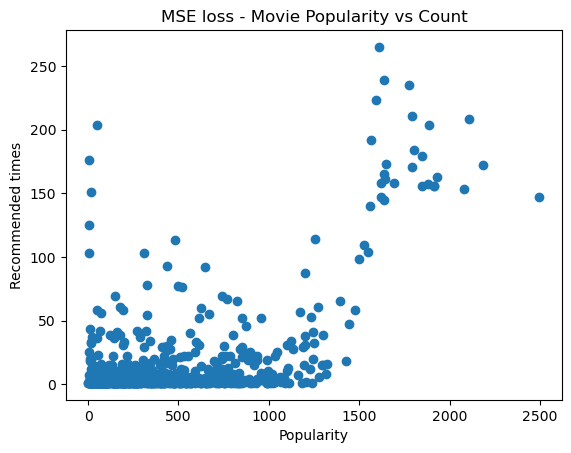

In [41]:
import matplotlib.pyplot as plt
import random
if TRAIN_FM_REG:
    most_recommended_REG = evaluate_FM_regression(val, FM_model_REG, None, TOP_model, train, at=25, use_ltr=False, sample=500)
    pop_database = train[['mid', 'popularity']].drop_duplicates()
    pop_database['most_reco_REG'] = pop_database['mid'].apply(lambda x: most_recommended_REG.get(x))
    plt.scatter(pop_database['popularity'], pop_database['most_reco_REG'])
    plt.xlabel('Popularity')
    plt.ylabel('Recommended times')
    plt.title('MSE loss - Movie Popularity vs Count')
    plt.show()

In [42]:
# Find last 10 movies seen by a user
uid = 2
top_10 = train[train['uid'] == uid].sort_values(by='timestamp', ascending=False).head(10)
print(f"========== LAST TEN MOVIES SEEN BY USER {uid} ==========")
for index, row in top_10.iterrows():
    print(f'{row.movie_name} - {row.rating} - {row.popularity}')
    
print(f"========== TOP 10 MOVIES RECOMMENDED TO USER {uid} ==========")
top_10_pred = predict_FM_regression(uid, FM_model_REG, None, TOP_model, train, at=25, use_ltr=False, thres=1)
for m in top_10_pred:
    print(f'{movies[movies.mid == m].movie_name.values[0]}')

========== LAST TEN MOVIES SEEN BY USER 2 ==========
Lost World: Jurassic Park, The (1997) - 4.0 - 886
Cliffhanger (1993) - 2.0 - 503
Jackal, The (1997) - 3.0 - 246
Armageddon (1998) - 3.0 - 807
Broken Arrow (1996) - 2.0 - 477
Outbreak (1995) - 3.0 - 544
Snake Eyes (1998) - 3.0 - 363
Twister (1996) - 4.0 - 812
Star Wars: Episode I - The Phantom Menace (1999) - 3.0 - 1620
Conspiracy Theory (1997) - 3.0 - 569
========== TOP 10 MOVIES RECOMMENDED TO USER 2 ==========
Schindler's List (1993)
Casablanca (1942)
It's a Wonderful Life (1946)
Sixth Sense, The (1999)
Apollo 13 (1995)
Apple, The (Sib) (1998)
Good Will Hunting (1997)
Mr. Smith Goes to Washington (1939)
West Side Story (1961)
E.T. the Extra-Terrestrial (1982)
Glory (1989)
Doctor Zhivago (1965)
Rain Man (1988)
Life Is Beautiful (La Vita è bella) (1997)
Bridge on the River Kwai, The (1957)
African Queen, The (1951)
Romeo and Juliet (1968)
Titanic (1997)
Witness (1985)
Sound of Music, The (1965)
Patriot, The (2000)
When Harry Met Sall

In [43]:
relevant_items = val[(val.uid==uid )].sort_values('rating', ascending=False).mid.values
if len(relevant_items)>0:
    recommended_items = predict_FM_regression(uid, FM_model_REG, None, TOP_model, train, use_ltr=False, at=25)

    cumulative_precision = precision(recommended_items, relevant_items)
    cumulative_recall = recall(recommended_items, relevant_items)
    cumulative_AP = AP(recommended_items, relevant_items)
print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_AP)) 

Recommender results are: Precision = 0.0000, Recall = 0.0000, MAP = 0.0000


### With weights

100%|██████████| 500/500 [15:02<00:00,  1.81s/it]

Recommender results are: Precision = 0.0305, Recall = 0.0848, MAP = 0.0246


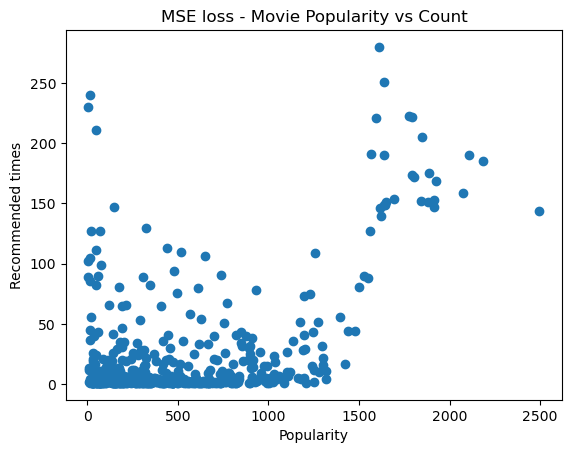

In [44]:
if TRAIN_FM_REG_W:
    most_recommended_REG_W = evaluate_FM_regression(val, FM_model_REG_W, None, TOP_model, train, at=25, use_ltr=False, sample=500)
    pop_database = train[['mid', 'popularity']].drop_duplicates()
    pop_database['most_reco_REG_W'] = pop_database['mid'].apply(lambda x: most_recommended_REG_W.get(x))
    plt.scatter(pop_database['popularity'], pop_database['most_reco_REG_W'])
    plt.xlabel('Popularity')
    plt.ylabel('Recommended times')
    plt.title('MSE loss - Movie Popularity vs Count')
    plt.show()

### Create submission of the models

In [45]:
CREATE_SUBMISSION_FM_REG = True
CREATE_SUBMISSION_FM_REG_W = True

In [46]:
if CREATE_SUBMISSION_FM_REG:
    # open the file in the write mode
    with open('solution_FM_REG.csv', 'w',encoding='UTF8') as f:
        # create the csv writer
        writer = csv.writer(f)
        # write a row to the csv file
        writer.writerow(['user_id', 'prediction'])
        for user_id in tqdm(test.uid.unique()):
            relevant_items = predict_FM_regression(user_id, FM_model_REG, None, TOP_model_comp, train_complete, use_ltr=False, at=25)
            list_relevants = ' '.join([str(elem) for elem in relevant_items])
            writer.writerow([str(user_id),list_relevants])
            
if CREATE_SUBMISSION_FM_REG_W:
    # open the file in the write mode
    with open('solution_FM_REG_W.csv', 'w',encoding='UTF8') as f:
        # create the csv writer
        writer = csv.writer(f)
        # write a row to the csv file
        writer.writerow(['user_id', 'prediction'])
        for user_id in tqdm(test.uid.unique()):
            relevant_items = predict_FM_regression(user_id, FM_model_REG_W, None, TOP_model_comp, train_complete, use_ltr=False, at=25)
            list_relevants = ' '.join([str(elem) for elem in relevant_items])
            writer.writerow([str(user_id),list_relevants])

100%|██████████| 6037/6037 [3:13:08<00:00,  1.92s/it]


## Classification FM approach

### Define input layers

In [47]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

def define_input_layers_classification():
    # encoded features
    mid_mean_input = Input((1,), name='input_mid_mean')
    pop_input = Input((1,), name='input_pop')
    age_input = Input((1,), name='age_input')
    num_inputs = [mid_mean_input, pop_input, age_input]
    # single level categorical features
    uid_input = Input((1,), name='input_uid') #user_id
    mid_input = Input((1,), name='input_mid')  #movie_id
    cat_sl_inputs = [uid_input, mid_input]

    # multi level categorical features (with 3 genres at most)
    genre_input = Input((3,), name='input_genre')
    cat_ml_inputs = [genre_input]

    inputs = num_inputs + cat_sl_inputs + cat_ml_inputs
    
    return inputs

### 1st order FM

In [48]:
def Tensor_Mean_Pooling(name = 'mean_pooling', keepdims = False):
    return Lambda(lambda x: K.mean(x, axis = 1, keepdims=keepdims), name = name)

def fm_1d_classification(inputs, n_uid, n_mid, n_genre):
    
    # user embedding + movie embedding + genre embedding + gender embedding
    mid_mean_input, pop_input, age_input, uid_input, mid_input, genre_input = inputs
    
    # all tensors are reshape to (None, 1)
    num_dense_1d = [Dense(1, name = 'num_dense_1d_mid_mean')(mid_mean_input),
                   Dense(1, name = 'num_dense_1d_pop')(pop_input),
                   Dense(1, name = 'num_dense_1d_age')(age_input)]
    cat_sl_embed_1d = [Embedding(n_uid + 1, 1, name = 'cat_embed_1d_uid')(uid_input),
                        Embedding(n_mid + 1, 1, name = 'cat_embed_1d_mid')(mid_input)]
    cat_ml_embed_1d = [Embedding(n_genre + 1, 1, mask_zero=True, name = 'cat_embed_1d_genre')(genre_input)]

    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d]
    cat_ml_embed_1d = [Tensor_Mean_Pooling(name = 'embed_1d_mean')(i) for i in cat_ml_embed_1d]
    
    # add all tensors
    y_fm_1d = Add(name = 'fm_1d_output')(num_dense_1d + cat_sl_embed_1d + cat_ml_embed_1d)
    
    return y_fm_1d

### 2nd order FM

In [49]:
def fm_2d_classification(inputs, n_uid, n_mid, n_genre, k):
    
    mid_mean_input, pop_input, age_input, uid_input, mid_input, genre_input = inputs
    
    num_dense_2d = [Dense(k, name = 'num_dense_2d_gender')(mid_mean_input),
                   Dense(k, name = 'num_dense_2d_pop')(pop_input),
                   Dense(k, name = 'num_dense_2d_age')(age_input)] # shape (None, k)
    num_dense_2d = [Reshape((1,k))(i) for i in num_dense_2d] # shape (None, 1, k)

    cat_sl_embed_2d = [Embedding(n_uid + 1, k, name = 'cat_embed_2d_uid')(uid_input), 
                       Embedding(n_mid + 1, k, name = 'cat_embed_2d_mid')(mid_input)] # shape (None, 1, k)
    
    cat_ml_embed_2d = [Embedding(n_genre + 1, k, name = 'cat_embed_2d_genre')(genre_input)] # shape (None, 3, k)
    cat_ml_embed_2d = [Tensor_Mean_Pooling(name = 'cat_embed_2d_genure_mean', keepdims=True)(i) for i in cat_ml_embed_2d] # shape (None, 1, k)

    # concatenate all 2d embed layers => (None, ?, k)
    embed_2d = Concatenate(axis=1, name = 'concat_embed_2d')(num_dense_2d + cat_sl_embed_2d + cat_ml_embed_2d)

    # calcuate the interactions by simplication
    # sum of (x1*x2) = sum of (0.5*[(xi)^2 - (xi^2)])
    tensor_sum = Lambda(lambda x: K.sum(x, axis = 1), name = 'sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name = 'square_of_tensors')

    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)

    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)

    sub = Subtract()([square_of_sum, sum_of_square])
    sub = Lambda(lambda x: x*0.5)(sub)
    y_fm_2d = Reshape((1,), name = 'fm_2d_output')(tensor_sum(sub))
    
    return y_fm_2d, embed_2d

### Put them together

In [50]:
def fm_model_classification(n_uid, n_mid, n_genre, k):
    
    inputs = define_input_layers_classification()
    
    y_fm_1d = fm_1d_classification(inputs, n_uid, n_mid, n_genre)
    y_fm_2d, embed_2d = fm_2d_classification(inputs, n_uid, n_mid, n_genre, k)
    
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d])
    y = Dense(1, activation='sigmoid', name = 'fm_output')(y)
    
    fm_model = Model(inputs, y)
    
    return fm_model

In [51]:
params_classification = {
    'n_uid': ratings.uid.max(),
    'n_mid': ratings.mid.max(),
    'n_genre': 14,
    'k': 10
}

### Prepare the data

In [52]:
def df2xy_classification(ratings):
    x = [ratings.norm_mean_mid.values,
         ratings.norm_pop.values,
         ratings.norm_age.values,
         ratings.uid.values, 
         ratings.mid.values,
         np.concatenate(ratings.movie_genre.values).reshape(-1,3)]
    y =  ratings.relevant.values
    return x,y

In [53]:
def df2x_classification(ratings):
    x = [ratings.norm_mean_mid.values,
         ratings.norm_pop.values,
         ratings.norm_age.values,
         ratings.uid.values, 
         ratings.mid.values,
         np.concatenate(ratings.movie_genre.values).reshape(-1,3)]
    return x

### Train classification FM model

In [54]:
from tensorflow.keras.callbacks import  EarlyStopping, ModelCheckpoint, LearningRateScheduler
import math
from tensorflow.keras import regularizers
from keras import backend as K
from itertools import product

def cosine_annealing_scheduler(epoch, lr, T_max=10):
    t_cur = epoch % T_max
    new_lr = lr * 0.5 * (1 + math.cos(math.pi * t_cur / T_max))
    if new_lr < 1e-5:
        return 1e-5
    else:
        return new_lr

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate

def train_FM_classification(t_set, v_set, FM_model, weighted=True):

    train_x, train_y = df2xy_classification(t_set)
    valid_x, valid_y = df2xy_classification(v_set)

    FM_model.compile(tf.keras.optimizers.Adam(1e-3),loss=tf.keras.losses.BinaryCrossentropy())

    if weighted:
        early_stop = EarlyStopping(monitor='val_loss', patience=3)
        model_ckp = ModelCheckpoint(filepath='./models/best_classification_weighted.h5', 
                                    monitor='val_loss',
                                    save_weights_only=True, 
                                    save_best_only=True)

        lr_scheduler = LearningRateScheduler(step_decay)
        callbacks = [model_ckp,early_stop]
    
        train_history = FM_model.fit(train_x, 
                                 train_y,
                                 epochs=100, 
                                 batch_size=128, 
                                 validation_data=(valid_x, valid_y),
                                 callbacks = callbacks,
                                 sample_weight=t_set['norm_pop'])
        FM_model.load_weights('./models/best_classification_weighted.h5')
        
    else:
        early_stop = EarlyStopping(monitor='val_loss', patience=3)
        model_ckp = ModelCheckpoint(filepath='./models/best_classification.h5', 
                                    monitor='val_loss',
                                    save_weights_only=True, 
                                    save_best_only=True)

        lr_scheduler = LearningRateScheduler(step_decay)
        callbacks = [model_ckp,early_stop]
    
        train_history = FM_model.fit(train_x, 
                                 train_y,
                                 epochs=100, 
                                 batch_size=128, 
                                 validation_data=(valid_x, valid_y),
                                 callbacks = callbacks)
        FM_model.load_weights('./models/best_classification.h5')
    
    return FM_model

def predict_top_FM_classification(uid, FM_model, at=None, get_seen_from=ratings):
    uid_mid_mat = pd.DataFrame(list(product([uid], (movies['mid'].unique()).tolist())), columns=['uid', 'mid'])
    uid_mid_mat = uid_mid_mat.join(movies.set_index('mid'), on = 'mid', how = 'left')
    uid_mid_mat = uid_mid_mat.join(users.set_index('uid'), on = 'uid', how = 'left')
    
    # ================== PERFORM THE SAME PREPROCESSING ====================
    uid_mid_mat = preprocess_test(uid_mid_mat, get_seen_from)
    # ======================================================================
    
    # Obtain x features
    mat_x = df2x_classification(uid_mid_mat)
    # Predict a rating for a given user for all the movies
    mat_predict = FM_model.predict(mat_x, verbose=0)
    # Create new column for the predicted rating
    uid_mid_mat['predicted_rating'] = mat_predict
    
    # Keep only unseen items
    merged = pd.merge(uid_mid_mat, get_seen_from, on=['uid', 'mid'], how='left', indicator=True)
    uid_mid_mat['seen'] = (merged['_merge'] == 'both')
    # Sort the unseen items
    unseen = uid_mid_mat[~uid_mid_mat['seen']].sort_values(by='predicted_rating', ascending=False)['mid'].tolist()

    predictions = []
    for m in unseen:
        predictions.append((m, uid_mid_mat[uid_mid_mat['mid']==m]['predicted_rating'].values[0]))
    
    if at is not None:
        return predictions[:at]
    else:
        return predictions

### Train without weights

In [55]:
# ---------------------
TRAIN_FM_CLASS = False
# ---------------------
if TRAIN_FM_CLASS:
    FM_model_CLASS = fm_model_classification(**params_classification)
    FM_model_CLASS = train_FM_classification(train, val, FM_model_CLASS, weighted=False)

### Train with weights

In [56]:
# ---------------------
TRAIN_FM_CLASS_W = False
# ---------------------
if TRAIN_FM_CLASS_W:
    FM_model_CLASS_W = fm_model_classification(**params_classification)
    FM_model_CLASS_W = train_FM_classification(train, val, FM_model_CLASS_W, weighted=True)

### Evaluate the models

In [57]:
def predict_FM_classification(uid, FM_model, LTR_model, TOP_model, get_seen_from, at=25, use_ltr=True, thres=40):
    
    cold_start = (get_seen_from['uid'].value_counts()[uid] < thres)
    
    if cold_start:
        return TOP_model.recommend(uid, at=at, remove_seen=True)
    else:
        FM_pred = predict_top_FM_classification(uid, FM_model, at=None, get_seen_from=get_seen_from)

        pred_list = sorted(FM_pred, key=lambda x: x[1], reverse=True)
        mid_list = [m[0] for m in pred_list]
        if use_ltr:
            return LTR_model.predict_top_LTR(uid, mid_list[:at+10], at=at, get_seen_from=get_seen_from)
        else:
            return mid_list[:at]

In [58]:
def evaluate_FM_classification(test, FM_model, LTR_model, TOP_model, get_seen_from, at=25, use_ltr=True, sample=None):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0
    
    movie_counts = defaultdict(int)
    
    if sample is not None:
        uids = test.uid.unique()
        for user_id in tqdm(random.choices(uids, k=sample)):
            relevant_items = test[(test.uid==user_id )].sort_values('rating', ascending=False).mid.values
            if len(relevant_items)>0:
                recommended_items = predict_FM_classification(user_id, FM_model, LTR_model, TOP_model, get_seen_from, use_ltr=use_ltr, at=at)
                num_eval+=1

                cumulative_precision += precision(recommended_items, relevant_items)
                cumulative_recall += recall(recommended_items, relevant_items)
                cumulative_AP += AP(recommended_items, relevant_items)
                
                for m in recommended_items:
                    movie_counts[m] += 1
                
    else:
        for user_id in tqdm(test.uid.unique()):
            relevant_items = test[(test.uid==user_id )].sort_values('rating', ascending=False).mid.values
            if len(relevant_items)>0:
                recommended_items = predict_FM_classification(user_id, FM_model, LTR_model, TOP_model, get_seen_from, use_ltr=use_ltr, at=at)
                num_eval+=1

                cumulative_precision += precision(recommended_items, relevant_items)
                cumulative_recall += recall(recommended_items, relevant_items)
                cumulative_AP += AP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 
    
    return movie_counts

### Without weights

In [59]:
import matplotlib.pyplot as plt
import random
if TRAIN_FM_CLASS:
    most_recommended_CLASS = evaluate_FM_classification(val, FM_model_CLASS, None, TOP_model, train, at=25, use_ltr=False, sample=500)
    pop_database = train[['mid', 'popularity']].drop_duplicates()
    pop_database['most_reco_CLASS'] = pop_database['mid'].apply(lambda x: most_recommended_CLASS.get(x))
    plt.scatter(pop_database['popularity'], pop_database['most_reco_CLASS'])
    plt.xlabel('Popularity')
    plt.ylabel('Recommended times')
    plt.title('BCE loss - Movie Popularity vs Count')
    plt.show()

### With weights

In [60]:
if TRAIN_FM_CLASS_W:
    most_recommended_CLASS_W = evaluate_FM_classification(val, FM_model_CLASS_W, None, TOP_model, train, at=25, use_ltr=False, sample=500)
    pop_database = train[['mid', 'popularity']].drop_duplicates()
    pop_database['most_reco_CLASS_W'] = pop_database['mid'].apply(lambda x: most_recommended_CLASS_W.get(x))
    plt.scatter(pop_database['popularity'], pop_database['most_reco_CLASS_W'])
    plt.xlabel('Popularity')
    plt.ylabel('Recommended times')
    plt.title('BCE loss - Movie Popularity vs Count')
    plt.show()

### Create submission of the models

In [61]:
CREATE_SUBMISSION_FM_CLASS = False
CREATE_SUBMISSION_FM_CLASS_W = False

In [62]:
import csv
if CREATE_SUBMISSION_FM_CLASS:
    # open the file in the write mode
    with open('solution_FM_CLASS.csv', 'w',encoding='UTF8') as f:
        # create the csv writer
        writer = csv.writer(f)
        # write a row to the csv file
        writer.writerow(['user_id', 'prediction'])
        for user_id in tqdm(test.uid.unique()):
            relevant_items = predict_FM_classification(user_id, FM_model_CLASS, None, TOP_model, train_complete, use_ltr=False, at=25)
            list_relevants = ' '.join([str(elem) for elem in relevant_items])
            writer.writerow([str(user_id),list_relevants])
            
if CREATE_SUBMISSION_FM_CLASS_W:
    # open the file in the write mode
    with open('solution_FM_CLASS_W.csv', 'w',encoding='UTF8') as f:
        # create the csv writer
        writer = csv.writer(f)
        # write a row to the csv file
        writer.writerow(['user_id', 'prediction'])
        for user_id in tqdm(test.uid.unique()):
            relevant_items = predict_FM_classification(user_id, FM_model_CLASS_W, None, TOP_model, train_complete, use_ltr=False, at=25)
            list_relevants = ' '.join([str(elem) for elem in relevant_items])
            writer.writerow([str(user_id),list_relevants])

# Trying to improve FM: Learning to Rank
We are going to use a listwise approach using the tensorflow ranking library. To do this, we can't just input the data directly since in the movielens data each row contains only the information of one user for one movie and a listwise approachh requires a list of items for every user. So we have to cinvert our training data.

In [63]:
import tensorflow_ranking as tfr
import tensorflow_recommenders as tfrs
import itertools
import pandas as pd

## Prepare the data

In [64]:
def generate_lists_of_movies(df, max_movies, max_lists=None):
    groups = df.groupby('uid')
    combs = []
    uids = df['uid'].unique()
    for uid, group in groups:
        if len(group) > 0:
            combs.append(itertools.combinations(
                group[['mid', 'rating']].apply(lambda row: tuple(row), axis=1),
                min(max_movies, group['mid'].shape[0])))
    if max_lists is not None:
        combs = [(uids[i], itertools.islice(comb, max_lists)) for i, comb in enumerate(combs)]
    rdf = pd.DataFrame({
        'uid': [uid for uid, comb in combs],
        'mids_ratings': [list(comb) for uid, comb in combs],
    }).explode('mids_ratings').reset_index(drop=True)
    
    rdf['mids'] = rdf['mids_ratings'].apply(lambda x: [int(t[0]) for t in x])
    rdf['ratings'] = rdf['mids_ratings'].apply(lambda x: [t[1] for t in x])
    
    rdf.drop('mids_ratings', axis=1, inplace=True)
    
    return rdf

In [65]:
train_ltr = generate_lists_of_movies(train, max_movies=25, max_lists=20)
val_ltr = generate_lists_of_movies(val, max_movies=25, max_lists=1)

In [66]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# pad movie IDs lists to a fixed length
max_len = 25
mids_padded_train = pad_sequences(train_ltr["mids"].values, maxlen=max_len, padding='post', value=0)
ratings_padded_train = pad_sequences(train_ltr["ratings"].values, maxlen=max_len, padding='post', value=0)

mids_padded_val = pad_sequences(val_ltr["mids"].values, maxlen=max_len, padding='post', value=0)
ratings_padded_val = pad_sequences(val_ltr["ratings"].values, maxlen=max_len, padding='post', value=0)

# create the dataset
train_ds = tf.data.Dataset.from_tensor_slices((
    {"uid": tf.constant(train_ltr["uid"].values), "mids": tf.constant(mids_padded_train)},
    tf.constant(ratings_padded_train)
)).batch(14000)

val_ds = tf.data.Dataset.from_tensor_slices((
    {"uid": tf.constant(val_ltr["uid"].values), "mids": tf.constant(mids_padded_val)},
    tf.constant(ratings_padded_val)
)).batch(14000)

In [67]:
unique_mids = train.mid.max()
print(f'Number of movies: {unique_mids}')
unique_uids = train.uid.max()
print(f'Number of users: {unique_uids}')

Number of movies: 3952
Number of users: 6040


## Define the model

In [68]:
class RankingModel(tfrs.Model):
    def __init__(self):
        super().__init__()
        embedding_dimension = 15

        # Compute embeddings for users.
        self.user_embeddings = tf.keras.layers.Embedding(unique_uids + 1, embedding_dimension)

        # Compute embeddings for movies.
        self.movie_embeddings = tf.keras.layers.Embedding(unique_mids + 1, embedding_dimension)

        # Compute predictions.
        self.score_model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
            # Make rating predictions in the final layer.
            tf.keras.layers.Dense(1)
        ])

        self.task = tfrs.tasks.Ranking(
            metrics=[
                tfr.keras.metrics.NDCGMetric(name="ndcg_metric"),
                tfr.keras.metrics.MeanAveragePrecisionMetric()
            ]
        )

    def call(self, features, training=False):
        uid_input, mids_input = features[0]["uid"], features[0]["mids"]

        # We first convert the id features into embeddings.
        # User embeddings are a [batch_size, embedding_dim] tensor.
        user_embeddings = self.user_embeddings(uid_input)

        # Movie embeddings are a [batch_size, num_movies_in_list, embedding_dim]
        # tensor.
        movie_embeddings = self.movie_embeddings(mids_input)

        # We want to concatenate user embeddings with movie embeddings to pass
        # them into the ranking model. To do so, we need to reshape the user
        # embeddings to match the shape of movie embeddings.
        list_length = mids_input.shape[1]
        user_embedding_repeated = tf.repeat(
            tf.expand_dims(user_embeddings, 1), [list_length], axis=1)

        # Once reshaped, we concatenate and pass into the dense layers to generate
        # predictions.
        concatenated_embeddings = tf.concat(
            [user_embedding_repeated, movie_embeddings], 2)

        return tf.squeeze(self.score_model(concatenated_embeddings), axis=-1)

    def compute_loss(self, features, training=False):
        labels = features[1]
        scores = self(features)

        return self.task(
            labels=tf.cast(labels, float, name=None),
            predictions=tf.cast(scores, float, name=None),
        )
    
    def predict_top_LTR(self, uid, mid_list, at=25, get_seen_from=ratings):
        pred_ltr = self.predict(({"uid": tf.constant([uid]), "mids": tf.constant([mid_list])},), verbose=0)[0]
        # Combine the two lists using zip
        combined = list(zip(pred_ltr, mid_list))
        # Sort the combined list based on the values of pred in descending order
        sorted_combined = sorted(combined, reverse=True)
        # Separate the sorted list into two separate lists
        sorted_pred, sorted_top = zip(*sorted_combined)
        return sorted_top[:at]

In [69]:
from tensorflow.keras.callbacks import  EarlyStopping, ModelCheckpoint, LearningRateScheduler
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate

def train_LTR(t_ds, v_ds):
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    model_ckp = ModelCheckpoint(filepath='./models/best_ltr.h5', 
                                monitor='val_loss',
                                save_weights_only=True, 
                                save_best_only=True)
    lr_scheduler = LearningRateScheduler(step_decay)
    callbacks = [model_ckp,early_stop]

    ltr_model = RankingModel()
    ltr_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tfr.keras.losses.ApproxNDCGLoss())
    ltr_model.fit(t_ds, epochs=60, batch_size=32, validation_data=v_ds, callbacks = callbacks)
    ltr_model.load_weights('./models/best_ltr.h5')
    return ltr_model

In [70]:
# ===================
TRAIN_LTR = False
# ===================

In [71]:
if TRAIN_LTR:
    LTR_model = train_LTR(train_ds, val_ds)

## Evaluate FM models with LTR

### FM as Regression without weights

In [72]:
import matplotlib.pyplot as plt
import random
if TRAIN_FM_REG and TRAIN_LTR:
    most_recommended_REG_LTR = evaluate_FM_regression(val, FM_model_REG, LTR_model, TOP_model, train, at=25, use_ltr=True, sample=500)
    pop_database = train[['mid', 'popularity']].drop_duplicates()
    pop_database['most_reco_REG_LTR'] = pop_database['mid'].apply(lambda x: most_recommended_REG_LTR.get(x))
    plt.scatter(pop_database['popularity'], pop_database['most_reco_REG_LTR'])
    plt.xlabel('Popularity')
    plt.ylabel('Recommended times')
    plt.title('MSE loss - Movie Popularity vs Count')
    plt.show()

### FM as Regression with weights

In [73]:
if TRAIN_FM_REG_W and TRAIN_LTR:
    most_recommended_REG_W_LTR = evaluate_FM_regression(val, FM_model_REG_W, LTR_model, TOP_model, train, at=25, use_ltr=True, sample=500)
    pop_database = train[['mid', 'popularity']].drop_duplicates()
    pop_database['most_reco_REG_W_LTR'] = pop_database['mid'].apply(lambda x: most_recommended_REG_W_LTR.get(x))
    plt.scatter(pop_database['popularity'], pop_database['most_reco_REG_W_LTR'])
    plt.xlabel('Popularity')
    plt.ylabel('Recommended times')
    plt.title('MSE loss - Movie Popularity vs Count')
    plt.show()

### FM as classification without weights

In [74]:
import matplotlib.pyplot as plt
import random
if TRAIN_FM_CLASS and TRAIN_LTR:
    most_recommended_CLASS_LTR = evaluate_FM_classification(val, FM_model_CLASS, LTR_model, TOP_model, train, at=25, use_ltr=True, sample=500)
    pop_database = train[['mid', 'popularity']].drop_duplicates()
    pop_database['most_reco_CLASS_LTR'] = pop_database['mid'].apply(lambda x: most_recommended_CLASS_LTR.get(x))
    plt.scatter(pop_database['popularity'], pop_database['most_reco_CLASS_LTR'])
    plt.xlabel('Popularity')
    plt.ylabel('Recommended times')
    plt.title('BCE loss - Movie Popularity vs Count')
    plt.show()

### FM as classification with weights

In [75]:
import matplotlib.pyplot as plt
import random
if TRAIN_FM_CLASS_W and TRAIN_LTR:
    most_recommended_CLASS_W_LTR = evaluate_FM_classification(val, FM_model_CLASS_W, LTR_model, TOP_model, train, at=25, use_ltr=True, sample=500)
    pop_database = train[['mid', 'popularity']].drop_duplicates()
    pop_database['most_reco_CLASS_W_LTR'] = pop_database['mid'].apply(lambda x: most_recommended_CLASS_W_LTR.get(x))
    plt.scatter(pop_database['popularity'], pop_database['most_reco_CLASS_W_LTR'])
    plt.xlabel('Popularity')
    plt.ylabel('Recommended times')
    plt.title('BCE loss - Movie Popularity vs Count')
    plt.show()

## Make submission 

In [76]:
import csv

if CREATE_SUBMISSION_FM_REG and TRAIN_LTR:
    # open the file in the write mode
    with open('solution_FM_REG_LTR.csv', 'w',encoding='UTF8') as f:
        # create the csv writer
        writer = csv.writer(f)
        # write a row to the csv file
        writer.writerow(['user_id', 'prediction'])
        for user_id in tqdm(test.uid.unique()):
            relevant_items = predict_FM_regression(user_id, FM_model_REG, LTR_model, TOP_model_comp, train_complete, use_ltr=True, at=25)
            list_relevants = ' '.join([str(elem) for elem in relevant_items])
            writer.writerow([str(user_id),list_relevants])
            
if CREATE_SUBMISSION_FM_REG_W and TRAIN_LTR:
    # open the file in the write mode
    with open('solution_FM_REG_W_LTR.csv', 'w',encoding='UTF8') as f:
        # create the csv writer
        writer = csv.writer(f)
        # write a row to the csv file
        writer.writerow(['user_id', 'prediction'])
        for user_id in tqdm(test.uid.unique()):
            relevant_items = predict_FM_regression(user_id, FM_model_REG_W, LTR_model, TOP_model_comp, train_complete, use_ltr=True, at=25)
            list_relevants = ' '.join([str(elem) for elem in relevant_items])
            writer.writerow([str(user_id),list_relevants])
            
if CREATE_SUBMISSION_FM_CLASS and TRAIN_LTR:
    # open the file in the write mode
    with open('solution_FM_CLASS_LTR.csv', 'w',encoding='UTF8') as f:
        # create the csv writer
        writer = csv.writer(f)
        # write a row to the csv file
        writer.writerow(['user_id', 'prediction'])
        for user_id in tqdm(test.uid.unique()):
            relevant_items = predict_FM_classification(user_id, FM_model_CLASS, LTR_model, TOP_model_comp, train_complete, use_ltr=True, at=25)
            list_relevants = ' '.join([str(elem) for elem in relevant_items])
            writer.writerow([str(user_id),list_relevants])
            
if CREATE_SUBMISSION_FM_CLASS_W and TRAIN_LTR:
    # open the file in the write mode
    with open('solution_FM_CLASS_W_LTR.csv', 'w',encoding='UTF8') as f:
        # create the csv writer
        writer = csv.writer(f)
        # write a row to the csv file
        writer.writerow(['user_id', 'prediction'])
        for user_id in tqdm(test.uid.unique()):
            relevant_items = predict_FM_classification(user_id, FM_model_CLASS_W, LTR_model, TOP_model_comp, train_complete, use_ltr=True, at=25)
            list_relevants = ' '.join([str(elem) for elem in relevant_items])
            writer.writerow([str(user_id),list_relevants])